In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

# Load Dataset

In [2]:
X_train = np.loadtxt('input.csv', delimiter = ',')
Y_train = np.loadtxt('labels.csv', delimiter = ',')

X_test = np.loadtxt('input_test.csv', delimiter = ',')
Y_test = np.loadtxt('labels_test.csv', delimiter = ',')

In [3]:
X_train = X_train.reshape(len(X_train), 100, 100, 3)
Y_train = Y_train.reshape(len(Y_train), 1)

X_test = X_test.reshape(len(X_test), 100, 100, 3)
Y_test = Y_test.reshape(len(Y_test), 1)

X_train = X_train/255.0
X_test = X_test/255.0

In [4]:
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ", Y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of Y_test: ", Y_test.shape)

Shape of X_train:  (2000, 100, 100, 3)
Shape of Y_train:  (2000, 1)
Shape of X_test:  (400, 100, 100, 3)
Shape of Y_test:  (400, 1)


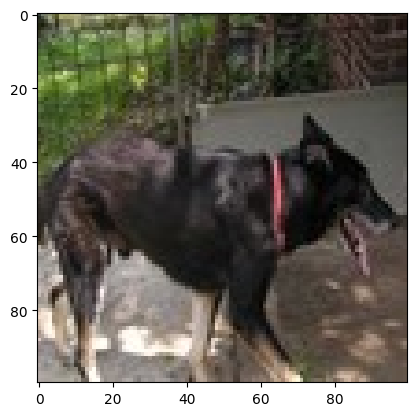

In [5]:
idx = random.randint(0, len(X_train))
plt.imshow(X_train[idx, :])
plt.show()

# Model

In [6]:
model = Sequential([
    Conv2D(32, (3,3), activation = 'relu', input_shape = (100, 100, 3)),
    MaxPooling2D((2,2)),
    
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [7]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (100, 100, 3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [8]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [9]:
model.fit(X_train, Y_train, epochs = 5, batch_size = 64)

Epoch 1/5
32/32 [==============================] - 23s 613ms/step - loss: 0.6951 - accuracy: 0.5405
Epoch 2/5
32/32 [==============================] - 20s 616ms/step - loss: 0.6404 - accuracy: 0.6490
Epoch 3/5
32/32 [==============================] - 20s 628ms/step - loss: 0.5474 - accuracy: 0.7240
Epoch 4/5
32/32 [==============================] - 20s 624ms/step - loss: 0.4903 - accuracy: 0.7725
Epoch 5/5
32/32 [==============================] - 19s 609ms/step - loss: 0.4481 - accuracy: 0.7970


In [10]:
model.evaluate(X_test, Y_test)

13/13 [==============================] - 2s 92ms/step - loss: 0.6593 - accuracy: 0.6275


[0.6593356132507324, 0.6274999976158142]

# Making predictions

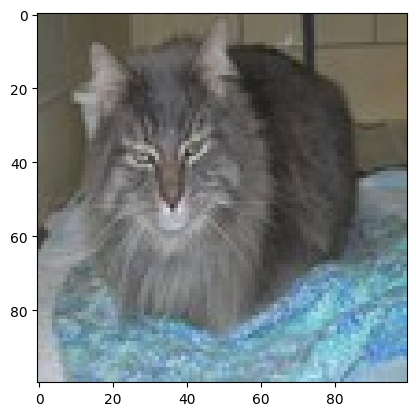

1/1 [==============================] - 0s 195ms/step
Our model says it is a : cat


In [11]:
idx2 = random.randint(0, len(Y_test))
plt.imshow(X_test[idx2, :])
plt.show()

y_pred = model.predict(X_test[idx2, :].reshape(1, 100, 100, 3))
y_pred = y_pred > 0.5

if(y_pred == 0):
    pred = 'dog'
else:
    pred = 'cat'
    
print("Our model says it is a :", pred)

# FGSM Attack

1/1 [==============================] - 0s 130ms/step


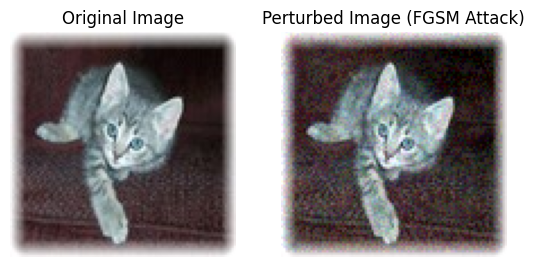

Model prediction on the perturbed image (FGSM Attack): dog


In [12]:
import tensorflow as tf

def fgsm_attack(model, image, epsilon):
    # Create a copy of the original image tensor
    perturbed_image = tf.identity(image)
    
    # Gradient tape to record operations for gradient calculation
    with tf.GradientTape() as tape:
        # Watch the input image tensor
        tape.watch(perturbed_image)
        
        # Generate the model predictions
        predictions = model(perturbed_image, training=False)
        
        # Reshape the predictions and labels to match
        predictions = tf.reshape(predictions, (1,))
        labels = tf.reshape(Y_test[idx2], (1,))
        
        # Calculate the loss using binary cross-entropy
        loss = tf.keras.losses.BinaryCrossentropy()(labels, predictions)
    
    # Get the gradients of the loss with respect to the input image
    gradients = tape.gradient(loss, perturbed_image)
    
    # Get the sign of the gradients
    gradient_signs = tf.sign(gradients)
    
    # Create the perturbed image by adding the epsilon sign
    perturbed_image = perturbed_image + epsilon * gradient_signs
    
    # Clip the perturbed image to ensure it stays within the valid range
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)
    
    return perturbed_image

# Select a random image from the test set
idx2 = random.randint(0, len(Y_test))
image = X_test[idx2, :].reshape(1, 100, 100, 3)

# Perform the FGSM attack with epsilon = 0.05
epsilon = 0.05
perturbed_image = fgsm_attack(model, image, epsilon)

# Make a prediction on the perturbed image
y_pred_perturbed = model.predict(perturbed_image)
y_pred_perturbed = y_pred_perturbed > 0.5

if y_pred_perturbed == 0:
    pred_perturbed = 'dog'
else:
    pred_perturbed = 'cat'

# Display the original and perturbed images
plt.subplot(1, 2, 1)
plt.imshow(image.reshape(100, 100, 3))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(perturbed_image.numpy().reshape(100, 100, 3))
plt.title('Perturbed Image (FGSM Attack)')
plt.axis('off')

plt.show()

print("Model prediction on the perturbed image (FGSM Attack):", pred_perturbed)


# Multiclass Attack

In [63]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import tensorflow as tf

In [64]:
# # Load the MNIST dataset
# (X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# # Preprocess the data
# X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255.0
# X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255.0

# # Convert the labels to one-hot encoding
# Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=10)
# Y_test = tf.keras.utils.to_categorical(Y_test, num_classes=10)

# # Create the model
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(10, activation='softmax')
# ])

# # Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train the model
# model.fit(X_train, Y_train, epochs=5, batch_size=64)

# # Evaluate the model
# model.evaluate(X_test, Y_test)

# # Select a random image from the test set
# idx = random.randint(0, len(X_test))
# image = X_test[idx].reshape(1, 28, 28, 1)

# # Perform the FGSM attack with epsilon = 0.1
# epsilon = 0.1

Epoch 1/5
938/938 [==============================] - 29s 30ms/step - loss: 0.2188 - accuracy: 0.9363
Epoch 2/5
938/938 [==============================] - 28s 29ms/step - loss: 0.0731 - accuracy: 0.9789
Epoch 3/5
938/938 [==============================] - 29s 30ms/step - loss: 0.0510 - accuracy: 0.9849
Epoch 4/5
938/938 [==============================] - 32s 34ms/step - loss: 0.0386 - accuracy: 0.9883
Epoch 5/5
313/313 [==============================] - 2s 7ms/step - loss: 0.0470 - accuracy: 0.9858


In [35]:
# From here it is correct

In [69]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Build the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))

# Evaluate the model
_, accuracy = model.evaluate(x_test, y_test)
print('Test Accuracy:', accuracy)

# Perform predictions
predictions = model.predict(x_test)

# Display images and predictions for digits 0 to 9

Epoch 1/5
469/469 [==============================] - 44s 90ms/step - loss: 0.2494 - accuracy: 0.9267 - val_loss: 0.0651 - val_accuracy: 0.9803
Epoch 2/5
469/469 [==============================] - 38s 80ms/step - loss: 0.0622 - accuracy: 0.9812 - val_loss: 0.0475 - val_accuracy: 0.9839
Epoch 3/5
469/469 [==============================] - 47s 100ms/step - loss: 0.0447 - accuracy: 0.9862 - val_loss: 0.0380 - val_accuracy: 0.9871
Epoch 4/5
469/469 [==============================] - 40s 86ms/step - loss: 0.0336 - accuracy: 0.9897 - val_loss: 0.0385 - val_accuracy: 0.9862
Epoch 5/5
313/313 [==============================] - 4s 12ms/step - loss: 0.0291 - accuracy: 0.9902
Test Accuracy: 0.9901999831199646
313/313 [==============================] - 3s 10ms/step


In [71]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.0291 - accuracy: 0.9902


[0.029135968536138535, 0.9901999831199646]

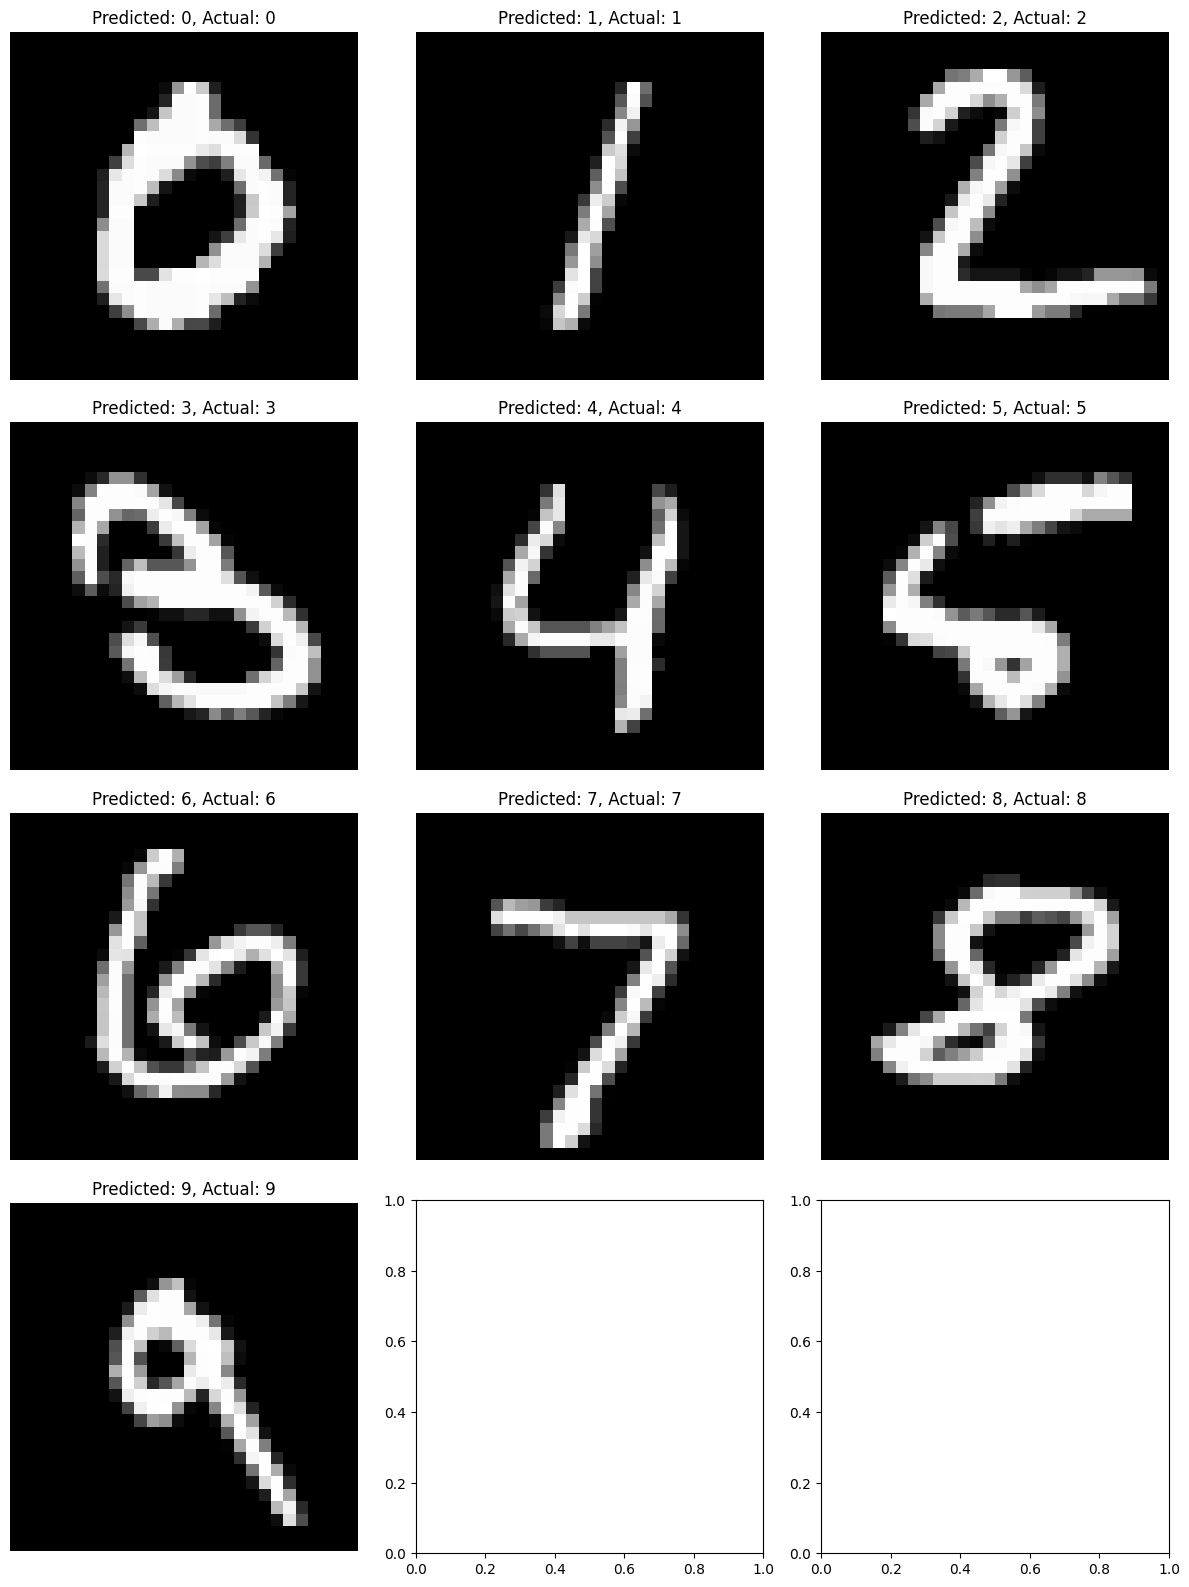

In [72]:
import matplotlib.pyplot as plt

digits_to_display = list(range(10))

if not digits_to_display:
    print("No digits to display.")
else:
    num_digits = len(digits_to_display)
    num_columns = 3
    num_rows = (num_digits - 1) // num_columns + 1
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(12, 4*num_rows))

    displayed_digits = []

    for i in range(len(x_test)):
        predicted_value = tf.argmax(predictions[i]).numpy()
        actual_value = y_test[i]

        if predicted_value in digits_to_display and predicted_value not in displayed_digits:
            digit_index = digits_to_display.index(predicted_value)
            row_index = digit_index // num_columns
            col_index = digit_index % num_columns

            ax = axs[row_index, col_index]
            ax.imshow(x_test[i].reshape(28, 28), cmap='gray')
            ax.set_title(f"Predicted: {predicted_value}, Actual: {actual_value}")
            ax.axis('off')

            displayed_digits.append(predicted_value)

        if len(displayed_digits) == num_digits:
            break

    plt.tight_layout()
    plt.show()


# FGSM Attack

In [73]:
def fgsm_attack(model, image, epsilon):
    # Create a copy of the original image tensor
    perturbed_image = tf.identity(image)
    
    # Gradient tape to record operations for gradient calculation
    with tf.GradientTape() as tape:
        # Watch the input image tensor
        tape.watch(perturbed_image)
        
        # Generate the model predictions
        predictions = model(perturbed_image, training=False)
        
        # Get the index of the predicted class
        target_class = tf.argmax(predictions[0])
        
        # Expand the dimensions of Y_test[idx] to match predictions
        target = tf.expand_dims(Y_test[idx], axis=0)
        
        # Calculate the loss using categorical cross-entropy
        loss = tf.keras.losses.categorical_crossentropy(target, predictions)
    
    # Get the gradients of the loss with respect to the input image
    gradients = tape.gradient(loss, perturbed_image)
    
    # Get the sign of the gradients
    gradient_signs = tf.sign(gradients)
    
    # Create the perturbed image by adding the epsilon sign
    perturbed_image = perturbed_image + epsilon * gradient_signs
    
    # Clip the perturbed image to ensure it stays within the valid range
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)
    
    return perturbed_image


Enter the value of epsilon0.3
1/1 [==============================] - 0s 27ms/step
Before Attack the pridicted value:  3
After FGSM Attack the pridicted value:  5


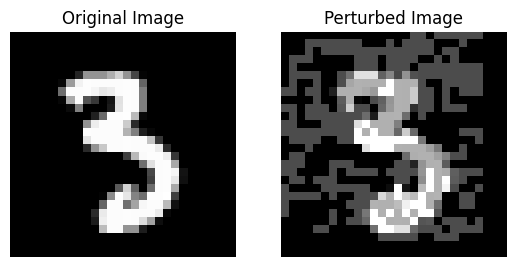

In [78]:
# Perform the FGSM attack
ep=float(input("Enter the value of epsilon"))
perturbed_image = fgsm_attack(model, image, ep)

# Make a prediction on the perturbed image
actual=model.predict(image)
actual=np.argmax(actual)
y_pred_perturbed = model.predict(perturbed_image)
y_pred_perturbed = np.argmax(y_pred_perturbed)
print("Actual value: ",actual)
print("After FGSM Attack the pridicted value: ",y_pred_perturbed)
# Display the original and perturbed images
plt.subplot(1, 2, 1)
plt.imshow(image.reshape(28, 28), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(perturbed_image.numpy().reshape(28, 28), cmap='gray')
plt.title('Perturbed Image')
plt.axis('off')

plt.show()